![CNN architecture](CNN architecture.jpg)
![NN training flow](NN training flow.JPG)


In [1]:
import csv
import cv2
import numpy as np

import matplotlib.image as mpimg
import matplotlib
import matplotlib.pyplot as plt
#import zipfile
import random
#zip = zipfile.ZipFile('./data.zip')

#zip.extractall('data1')
%matplotlib inline

## Read train data

### The amount of original sampled images that is required to get a successful training is tested. I first tried 2000 samples, which would eventually generate 30K images, and the training model passed the test. Then I reduced the number of samples to 1000, which would generate 18k images in the end, and it still passed the test, and its driving behaviors looked no obvious difference with the one having more sample data.  Finally, I reduced it to 500, which generated 9k images, and it failed at the very sharp corner around the lake. 

In [2]:
lines = []

with open('./train/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

lines_rand = random.sample(lines,100)

del lines

lines = []

lines = lines_rand

del lines_rand

len(lines)

100

## Import train data

In [3]:
#print(len(lines))

## Data Augument 1: convert original bgr channels to RGB and YUV, and keep all the images. In this way, we augument data to 3 times.

In [4]:
images = []
measurements = []
for line in lines:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('\\')[-1]
    #print(filename)
        current_path = './train/IMG/' + filename
        image = cv2.imread(current_path)
    #print(image.shape)
        images.append(image)
        img_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        img_yuv = cv2.cvtColor(image,cv2.COLOR_BGR2YUV)
        images.append(img_rgb)
        images.append(img_yuv)   
    #apply correction of 0.2 to left and right images
    
    # i = 0,1,2 for center, left and right, respectively
        if i == 0:
            measurement = float(line[3])
        else:
            measurement = float(line[3]) + (-0.2)*i + 0.3
    #print(measurement)
        measurements.append(measurement)
        measurements.append(measurement)
        measurements.append(measurement)


#X_train = np.array(images)
#y_train = np.array(measurements)
print(len(images),len(measurements))

900 900


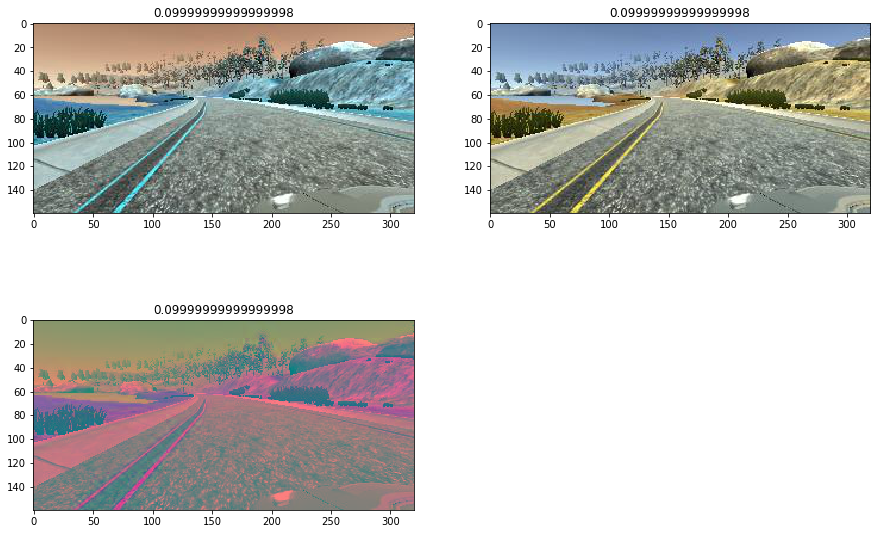

In [5]:
fig = plt.figure(figsize=(15,10)) 
fig.add_subplot(2,2,1)
plt.title(measurements[3])
plt.imshow(images[3])

plt.subplot(2,2,2)
plt.title(measurements[4])
plt.imshow(images[4])

plt.subplot(2,2,3)
plt.title(measurements[5])
plt.imshow(images[5])


## Data Pre-processing (normalization, regularization, flip images etc)

### Note: matplotlib complaint about the negative values of pixels in the image, as a consequence I had to rescale the vaules to 0 to 1, instead of -0.5 to 0.5.

### Flip images

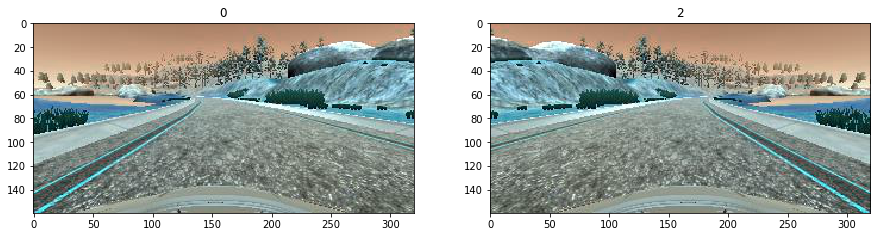

In [6]:
#img0 = cv2.flip(X_train[0],0)
img1 = cv2.flip(images[0],1)
#img2 = cv2.flip(X_train[0],-1)

fig = plt.figure(figsize=(15,10)) 
fig.add_subplot(2,2,1)
plt.title('0')
plt.imshow(images[0])

plt.subplot(2,2,2)
plt.title('2')
plt.imshow(img1)


In [7]:
## flip all the images taken by left and right cameras. 
X_train = []
y_train = []
for i in range(len(images)):
    X_flip = cv2.flip(images[i],1)
    y_flip = -1 * measurements[i]
    X_train.append(images[i])
    X_train.append(X_flip)
    y_train.append(measurements[i])
    y_train.append(y_flip)

len(X_train)

1800

In [8]:
X_train = np.array(X_train)
y_train = np.array(y_train)

## Set up keras

In [9]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Activation, Dropout, Cropping2D, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.utils import shuffle
from keras.callbacks import TensorBoard

#X_train, y_train = shuffle(X_train, y_train)

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((60,25),(0,0)), input_shape = (160,320,3)))

model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Dropout(0.8))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
#model.add(Dense(10))
model.add(Dense(10, activation = 'elu'))
model.add(Dense(1))
model.summary()

tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0,write_graph=True, write_images=True)

model.compile(loss = 'mse', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 5, callbacks=[tensorboard])

model.save('model.h5')

Using TensorFlow backend.
C:\Users\alany\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  
C:\Users\alany\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  from ipykernel import kernelapp as app
C:\Users\alany\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  app.launch_new_instance()
C:\Users\alany\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
C:\Users\alany\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Co

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 75, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 33, 64)         36928     
__________

C:\Users\alany\Anaconda3\envs\carnd-term1\lib\site-packages\keras\models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1440 samples, validate on 360 samples
Epoch 1/5
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0723 - acc: 0.2417 - val_loss: 0.0933 - val_acc: 0.2000
Epoch 2/5
1440/1440 [==============================] - 2s 1ms/step - loss: 0.0605 - acc: 0.2417 - val_loss: 0.0757 - val_acc: 0.1972
Epoch 3/5
1440/1440 [==============================] - 2s 1ms/step - loss: 0.0596 - acc: 0.2417 - val_loss: 0.0731 - val_acc: 0.2000
Epoch 4/5
1440/1440 [==============================] - 2s 2ms/step - loss: 0.0501 - acc: 0.2424 - val_loss: 0.0764 - val_acc: 0.2000
Epoch 5/5
1440/1440 [==============================] - 2s 2ms/step - loss: 0.0475 - acc: 0.2437 - val_loss: 0.0800 - val_acc: 0.2000
